<a href="https://colab.research.google.com/github/dina-lab3D/ContactNet/blob/master/ContactNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Antigen-antibody docking tutorial
<img src="https://drive.google.com/uc?export=view&id=1J6FA12dZKcf7ydSQdnFo8b7bwi-NehB5" width="300">
<img src="https://drive.google.com/uc?export=view&id=1J83QaZWoK1Xi2-dqt7o8jdImcJ8HDJf-" width="150">

In this tutorial we use a docking software to dock a modeled antibody to an antigen. We will work in 2 steps:


1. Docking using PatchDock
2. Scoring using interface scoring function ContactNet



In [ ]:
#@title Download docking software - PatchDock
!wget https://github.com/dina-lab3D/tutorials/raw/main/PatchDock/pd.zip
!unzip pd.zip

In [ ]:
#@title Download and install ContactNet
%cd /content/
!git clone https://github.com/dina-lab3D/ContactNet --quiet
!pip install tensorflow_addons
!pip install wandb
%cd ContactNet/src/ComplexDistogram/
!cmake .
!make


In [3]:
#@title Prepare input for docking in the example folder
%cd /content/
%mkdir example
!cp /content/ContactNet/example/*.pdb /content/example/

/content


In [4]:
#@title run PatchDock
%cd /content/example/
# dock the antibody model to the antigen, final clustering of 4A, "AA" tells PatchDock to use antigen-antibody docking and focus on nanobody CDRs
! ../PatchDock/buildParams.pl 1kip_Ag.pdb 1kip_AF2_Ab.pdb 4.0 AA
! ../PatchDock/patch_dock.Linux params.txt docking.res
# generate top 10 by geometric score
! ../PatchDock/transOutput.pl docking.res 1 10

/content/example
numberOfChains: 2
AB
Number of vdW radius types: 15
Total number of atoms: 1001
Calculation of surface of 1001 atoms, with surface point density 10 and probe radius 1.8
150 yon and 471 victim probes
394 saddle and 255 concave surface points removed during non-symmetry overlapping reentrant surface removal
16941 contact, 34062 reentrant, and 51003 total surface points
Contact area: 1772.13; reentrant area: 3470.58; total area: 5242.71
    In Layer 0 out of 13 curr->size() 23509
    In Layer 1 out of 13 curr->size() 62078
    In Layer 2 out of 13 curr->size() 62725
    In Layer 3 out of 13 curr->size() 66074
    In Layer 4 out of 13 curr->size() 70997
    In Layer 5 out of 13 curr->size() 78906
    In Layer 6 out of 13 curr->size() 88530
    In Layer 7 out of 13 curr->size() 97761
    In Layer 8 out of 13 curr->size() 106140
    In Layer 9 out of 13 curr->size() 114146
    In Layer 10 out of 13 curr->size() 121789
    In Layer 11 out of 13 curr->size() 129884
    In Laye

In [8]:
#@title run ContactNet scoring
!python3 /content/ContactNet/data_maker.py 1kip_Ag.pdb 1kip_AF2_Ab.pdb docking.res --trans_num 1000 >& tmp
!python3 /content/ContactNet/predict_prot.py 1kip_Ag.pdb 1kip_AF2_Ab.pdb --trans_num 1000 >& tmp2

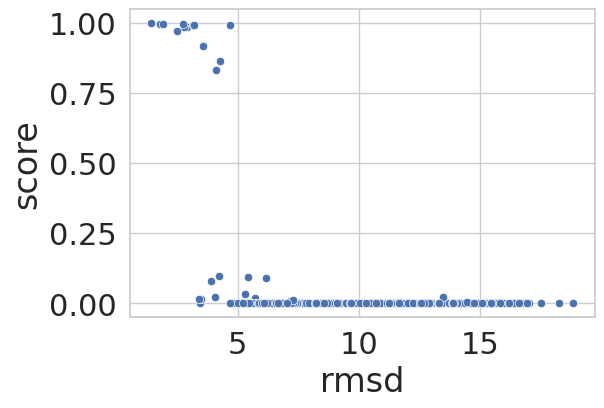

122


<Figure size 640x480 with 0 Axes>

In [9]:
#@title plot scores vs. RMSDs (funnel)

# create a file with interface rmsds and the scores
!grep "|" docking.res | awk '{print $1" "$4} ' | tr '(' ' ' | tr ')' ' ' > rmsds
!sed -i 's/|/rmsd/' rmsds
!cut -f2 evaluation > cnet
!paste -d ' ' rmsds cnet | head -1001 > all_scores.txt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
from scipy import stats
from scipy.interpolate import make_interp_spline

df = pd.read_csv("all_scores.txt", delimiter=r"\s+")
#print (df)
sns.set_theme(style="whitegrid")
sns.set(font_scale = 2)
sns.set_style("whitegrid")

fig1 = plt.figure(1, figsize=(6, 4), dpi=100)

sns.scatterplot(data = df,x="rmsd", y="score")
plt.show()
plt.savefig('scatter.png')

# select best model
best_model = int(df["#"].iloc[df["score"].argmax()])
print(best_model)




In [10]:
!pip install py3Dmol
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob

#@title Display best scoring model
! /content/PatchDock/transOutput.pl docking.res $best_model $best_model
with open("1kip_AF2_Ab.pdb") as ifile:
    true = "".join([x for x in ifile])
with open(f"docking.res.{best_model}.pdb") as ifile:
    predicted = "".join([x for x in ifile])


r,g,b = 255,0,0
print(f"\033[38;2;{r};{g};{b}mPredicted model \033[38;2;255;255;255m")
r,g,b = 0,0,255
print(f"\033[38;2;{r};{g};{b}mNative structure \033[38;2;255;255;255m")
view = py3Dmol.view(width=500, height=500)
view.addModelsAsFrames(predicted)
view.setStyle({'model': 0, "chain": "C"}, {"cartoon": {'arrows':True, 'color': 'gray'}})
view.setStyle({'model': 0, "chain": "A"}, {"cartoon": {'arrows':True, 'color': 'red'}})
view.setStyle({'model': 0, "chain": "B"}, {"cartoon": {'arrows':True, 'color': 'red'}})
view.addModelsAsFrames(true)
view.setStyle({'model': 1}, {"cartoon": {'arrows':True, 'color': 'blue'}})
view.zoomTo()
view.show()


Ligand PDB: 1kip_AF2_Ab.pdb
Receptor PDB: 1kip_Ag.pdb
/content/PatchDock/pdb_trans  0.13271 -0.10741 0.18654 2.14388 -7.61484 5.84685 < 1kip_AF2_Ab.pdb >> docking.res.122.pdb
Predicted model 
Native structure 


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol